In [284]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim

from network_utils import get_capacity, to_numpy, plot_weights_hist, train
from metric_utils import calculate_Q_metrics, strain, l2_loss
from input_utils import create_data, make_random_plane

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:

def kurtosis(X):
    '''
    X - [:,T]
    '''
    mean = X.mean(1, keepdim=True)
    std = X.std(1, keepdim=True)
    
    return mean**4 / std**4


def f1(X):
    return 0.5*(X**2)

In [339]:
X = torch.randn(1,2, requires_grad=True)
g1 = lambda X: torch.autograd.grad(f1(X).mean(),X)[0]

In [340]:
g1(X)

tensor([[ 0.3905, -0.4443]])

In [341]:
X

tensor([[ 0.7809, -0.8886]], requires_grad=True)

In [314]:
X.shape

torch.Size([1, 50])

In [309]:
g1(X)[0].shape

torch.Size([1, 50])

In [288]:
torch.gradient()

tensor(0.0004, grad_fn=<DivBackward0>)

# Load data 

### Visualize

In [209]:
# n_samples = 1000
# I_test, theta_test = make_s_curve(n_samples=n_samples, noise=1e-2) 
# I_test = StandardScaler().fit_transform(I_test).T
# theta_test -= np.mean(theta_test)
# theta_test = MinMaxScaler((-1,1)).fit_transform(theta_test[:,None]).flatten()

SCALER = MinMaxScaler(feature_range=(-1,1))

n_samples = 1000
I, _ = make_random_plane(n_samples=n_samples, noise=1e-1) 
I = SCALER.fit_transform(I).T

In [210]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(I.T[:,:3], columns=['x','y', 'z'])
# if theta_test is not None:
#     df['target'] = theta_test
#     fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')
# else:
#     fig = px.scatter_3d(df, x='x', y='y', z='z')

# fig.show()

In [211]:
# umap = UMAP(n_neighbors=20)
# Z_f = umap.fit_transform(I_test)
# plt.scatter(Z_f[:,0], Z_f[:,1], c=theta_test)

In [212]:
# datasets = {'s_curve':make_s_curve,
# #             'swiss_roll':make_swiss_roll,
#             'plane':make_random_plane}

# datasets_parameters = {'s_curve': s_curve_input,
#                        'plane': plane_input}

In [214]:
input_parameters = {'generator': make_s_curve, #make_s_curve, 
                    'generator_kwargs': {'n_samples':1000, 'noise':1e-1}, # 1e-1
                    'normalize':True,
                    'unsupervised':True,
                    'scaler':SCALER}

# input_parameters = {'generator': make_random_plane, # make_s_curve, 
#                     'generator_kwargs': {'n_samples':1000, 'noise':1e-2, 'W':np.random.randn(3,2)}, # 1e-1
#                     'normalize':True,
#                     'unsupervised':True}

inpt, outpt = create_data(**input_parameters)
inpt_test, outpt_test = create_data(**input_parameters)

In [215]:
inpt.shape, inpt_test.shape

((3, 1000), (3, 1000))

In [218]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(np.concatenate([inpt, inpt_test], axis=1).T, columns=['x','y', 'z'])
# df['target'] = np.concatenate([np.zeros((inpt.shape[1])), 
#                                np.ones((inpt_test.shape[1]))])

# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

# fig.show()

In [219]:
# N_indep = 10 # number of independent neurons
# rf_dt = 1 # receptive field dt
# sygma = 0.3 # less than 0.5
# redundancy = 1
# add_noise=False
# kernel_conv=0
# normalize = False

# input_parameters = {'N_I':N_indep, 
#                     'receptive_field_dt':rf_dt, 
#                     'T':T,
#                     'sygma':sygma, 
#                     'redundancy':redundancy,
#                     'add_noise':add_noise,
#                     'kernel_conv':kernel_conv,
#                     'normalize':normalize}

# I = create_I(**input_parameters) 
# I_test = create_I(**input_parameters) 

# N_I = I.shape[0]

In [220]:
# # plt.figure(figsize=(10,10))
# plt.imshow(I)
# plt.ylabel('# Neuron', fontsize=20)
# plt.xlabel('time', fontsize=20)
# plt.title('Input', fontsize=20)
# plt.show()

In [221]:
# # plt.figure(figsize=(10,10))
# plt.imshow(I_test)
# plt.ylabel('# Neuron', fontsize=20)
# plt.xlabel('time', fontsize=20)
# plt.title('Input', fontsize=20)
# plt.show()

# PCA

In [222]:
N_CYCLES = 3
data = [create_data(**input_parameters)   for _ in range(N_CYCLES)]
inpt_data = np.concatenate([d[0] for d in data],-1)

3


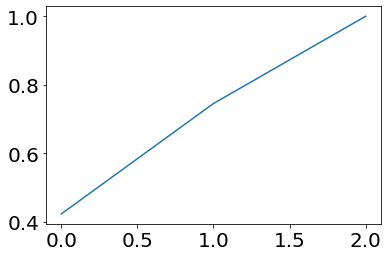

In [223]:
pca = PCA()
pca.fit(inpt_data.T)
pca_ev = np.cumsum(pca.explained_variance_ratio_)
print((np.arange(1,inpt_data.shape[0]+1)[pca_ev > 0.99])[0])
plt.plot(pca_ev)
plt.show()

In [280]:
import pynndescent
index = pynndescent.NNDescent(inpt_data.T, metric="euclidean")
index.prepare() 123

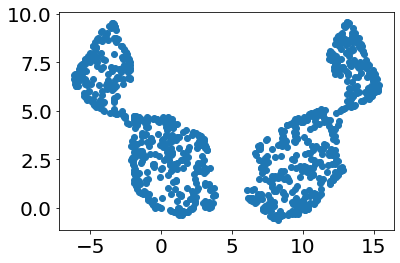

In [263]:
umap = UMAP(n_components=2, n_neighbors=50, n_jobs=1)
Z = umap.fit_transform(inpt_data.T)
Z_test = umap.transform(inpt_test.T)
plt.scatter(Z_test[:,0], Z_test[:,1]) # , c=theta_data

In [264]:
calculate_Q_metrics(inpt_data.T, Z)

(0.7660576842739221, 0.8060481286640294)

In [266]:
Q_loc_val_UMAP, Q_glob_val_UMAP = calculate_Q_metrics(inpt_test.T, Z_test)

In [267]:
Q_loc_val_UMAP, Q_glob_val_UMAP

(0.7313127706771625, 0.7980273903568754)

In [273]:
strain(Z_test.T, inpt_test)

6061337057.050802

# Train MLP

In [227]:
def init_weights(self):
    for p in self.parameters():
        nn.init.xavier_normal_(p)

class f_theta(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=100):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.theta1 = nn.Parameter(torch.zeros(self.hidden_dim, self.input_dim, requires_grad=True))
        self.bias1 = nn.Parameter(torch.zeros(self.hidden_dim, self.input_dim, requires_grad=True))
        self.theta2 = nn.Parameter(torch.zeros(1, self.hidden_dim, requires_grad=True))
        
        init_weights(self)
        
    def forward(self, x):
        
        '''
        x - [d, T]
        '''
        
        x = torch.sigmoid(x.unsqueeze(0) * self.theta1.unsqueeze(-1) + self.bias1.unsqueeze(-1))
        x = torch.einsum('mh,hdt->mdt', self.theta2, x).squeeze(0)
        
        return x

In [230]:
class MLP_NonlinearEncoder(nn.Module):
    
    '''
    Feed-forward MLP without recurrent connections
    '''
    
    def __init__(self,**kwargs):
        
        super(MLP_NonlinearEncoder, self).__init__()
        
        for k, v in kwargs.items():
            setattr(self, k, v)
            
        # initialize
        if self.set_seed:
            torch.manual_seed(self.seed)
            
        W_s = [nn.Parameter(torch.zeros(self.hidden_dim, self.input_dim, requires_grad=True))]
        self.f_s = [self.create_f(self.hidden_dim)]
        if self.add_bn:
            BN_s = [nn.BatchNorm1d(self.input_dim, affine=False, track_running_stats=False)]
        
        for layer in range(1,self.layers_number):
            
            if layer == self.layers_number - 1:
                output_dim = self.embedding_dim
            else:
                output_dim = self.hidden_dim
                
            W_s.append(nn.Parameter(torch.zeros(output_dim, self.hidden_dim, requires_grad=True)))
            if self.add_bn:
                BN_s.append(nn.BatchNorm1d(output_dim, affine=False, track_running_stats=False))
            self.f_s.append(self.create_f(output_dim))
        
        # create parameter lists
        self.W_s = nn.ParameterList(W_s)
        if self.parametrized_f:
            self.f_s = nn.ModuleList(self.f_s)
        if self.add_bn:
            self.BN_s = nn.ModuleList(BN_s)
        
        init_weights(self)

    def create_f(self, input_dim):
        if self.parametrized_f:
            return f_theta(input_dim, self.f_hidden_dim)
        else:
            # default
            return self.default_nonlinearity
    
    def hebbian_update(self, W, inp, out, learning_type='Oja', weight_decay=1e-1):
        
        '''
        inp - [d1,T], layer input 
        out - [d2,T], layer output
        W - [d2, d1]
        '''
        T = inp.shape[1]
        
        if learning_type=='Oja':
            
            dW = (out@inp.T)/T - out@(out.T@W)/T  #  [h,:] [:,h] @ [h,d] 
            
        elif learning_type=='Hebb':
            
            dW = (out@inp.T)/T - weight_decay*W
            
        elif learning_type=='GHA':
            raise NotImplementedError()
                
        elif learning_type=='NonlinearGHA':
            raise NotImplementedError()
            
        elif learning_type=='GHA':
            raise NotImplementedError()
            
        else:
            raise RuntimeError('Only ["BP", "Hebb", "Oja"] rules are supported!')
                
        return dW
        
    def hebbian_learning_step(self, 
                              inpt, 
                              X_s, 
                              outpt, 
                              learning_type='Oja', 
                              learning_rate=1e-1, 
                              weight_decay=1e-1):
        
        '''
        inpt - [d,T] - input data
        X_s - [[h_1,T], ..., [h_k,T]]
        Y - [1,T]
        Y_true - [1,T]
        '''
        
        assert learning_type in ['Oja']
        
        inp = inpt 
        # hebbian update for intermediate layers
        for i, W in enumerate(self.W_s):
            out = X_s[i]
            dW = self.hebbian_update(W.data, inp, out, learning_type=learning_type, weight_decay=weight_decay)
            W.data = W.data + learning_rate*dW
            self.W_s[i].data = W.data
            inp = out
        
    def forward(self,I):
        
        '''
        I - [d,T]
        '''
        
        X = I
        X_s = []
        
        for i, W in enumerate(self.W_s):
            if self.add_bn:
                # transpose to [T,d] and back to [d,T]
                X = self.BN_s[i](X.T).T 
            X = self.f_s[i](W@X)
            X_s.append(X)
            
        return X_s

In [231]:
input_dim = I.shape[0]
embedding_dim = 2 #input_dim
DEFAULT_ACTIVATION_FUNCTION = torch.tanh # torch.relu_
ADD_BN = True
SET_SEED = False
SEED = 42

encoder_parameters = {'input_dim':input_dim,
                    'hidden_dim':input_dim*5,
                    'embedding_dim':embedding_dim,
                    'parametrized_f': False,
                    'default_nonlinearity':DEFAULT_ACTIVATION_FUNCTION,
                    'layers_number':4,
                    'add_bn':ADD_BN,
                    'seed':SEED,
                    'set_seed':SET_SEED
                     }


# here we add BN
decoder_parameters = {'input_dim':embedding_dim,
                    'hidden_dim':embedding_dim*5,
                    'output_dim':input_dim, # output dimension
                    'default_nonlinearity':DEFAULT_ACTIVATION_FUNCTION,
                    'hidden_layers_number':4,
                    'bias':False,
                    'add_bn':ADD_BN,
                    'seed':SEED,
                    'set_seed':SET_SEED
                     }

encoder = MLP_NonlinearEncoder(**parameters).to(device)
decoder = MLP_NonlinearDecoder(**decoder_parameters).to(device)


encoder_decoder_parameters = {'encoder':encoder,
                              'decoder':decoder,
                              'seed':SEED,
                              'set_seed':SET_SEED
                             }

encoder_decoder = MLP_EncoderDecoder(**encoder_decoder_parameters).to(device)

In [232]:
for name,param in encoder_decoder.named_parameters():
    print(name, param.shape)

encoder.W_s.0 torch.Size([15, 3])
encoder.W_s.1 torch.Size([15, 15])
encoder.W_s.2 torch.Size([15, 15])
encoder.W_s.3 torch.Size([2, 15])
decoder.hidden_layers.0.weight torch.Size([10, 2])
decoder.hidden_layers.2.weight torch.Size([10, 10])
decoder.hidden_layers.4.weight torch.Size([10, 10])
decoder.hidden_layers.6.weight torch.Size([10, 10])
decoder.output_layer.weight torch.Size([3, 10])


In [233]:
inpt, outp = create_data(**input_parameters)
inpt_torch = torch.tensor(inpt,dtype=torch.float).to(device)
inpt_torch_test = torch.tensor(inpt_test, dtype=torch.float).to(device)
outpt_torch_test = torch.tensor(outpt_test, dtype=torch.float).to(device)

In [234]:
X_s = encoder.forward(inpt_torch_test)

In [235]:
assert encoder_decoder(inpt_torch_test)[-1].shape == inpt_torch_test.shape

In [236]:
for X in X_s:
    print(X.shape)

torch.Size([15, 1000])
torch.Size([15, 1000])
torch.Size([15, 1000])
torch.Size([2, 1000])


In [275]:
# network = MLP_EncoderDecoder(**encoder_decoder_parameters).to(device)
network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

T = I.shape[1]

training_parameters = edict({'learning_type':'Oja',\
                       'epochs':100,
                       'lr':1e-3, # learning-rate 
                       'batch_size':1, # batch-size
                       'tol':1e-2, # loss tolerance for early stopping 
                       'wd':None, # weight-decay
                       'shuffle':True, # shuffle data
                       'progress_bar':True,
                       'weight_saver':None,
                       'calculate_grad':True,
                       'clip_grad_value': 0.1,
                       'val_metrics': None,
                       'device':device
                       })

opt = optim.Adam(network.parameters(), lr=training_parameters.lr, weight_decay=0)

In [249]:
# # hebbian learning
# network.W_s.requires_grad = False
# lr_θ = 1e-3
# opt_theta = optim.Adam(filter(lambda x: x.requires_grad network.parameters()), lr=lr_θ, weight_decay=0)

In [276]:
# network, opt, metric_dict = train(network, 
#                                   opt=opt, 
#                                   criterion=l2_loss,
#                                   train_params=training_parameters,
#                                   data_params=input_parameters, 
#                                   val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
#                                   metric_dict=None 
#                                   )


network, opt, metric_dict = train(network, 
                                  opt=opt, 
                                  criterion=strain, #l2_loss,
                                  train_params=training_parameters,
                                  data_params=input_parameters, 
                                  val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
                                  metric_dict=None 
                                  )

  0%|                                                                                                                                                | 0/100 [00:00<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 3])

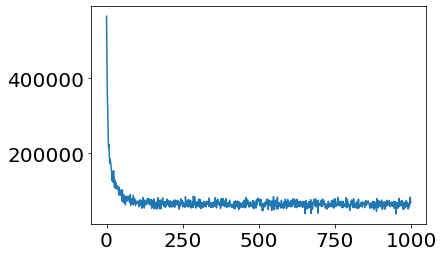

In [251]:
plt.plot(metric_dict['loss_train']) 

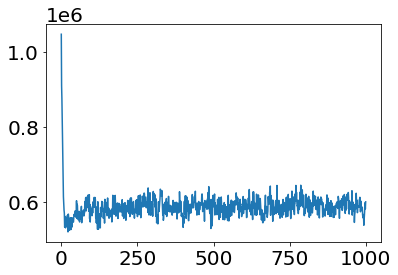

In [252]:
plt.plot(metric_dict['loss_val'])

In [258]:
if isinstance(network, MLP_NonlinearEncoder):
    Z_train_pred = to_numpy(metric_dict['outpt_train'][-1])
    Z_val_pred = to_numpy(metric_dict['outpt_val'][-1])
else:
    Z_train_pred = to_numpy(metric_dict['outpt_train'][-2])
    Z_val_pred = to_numpy(metric_dict['outpt_val'][-2])
    
    outpt_train_pred = to_numpy(metric_dict['outpt_train'][-1])
    T_train = outpt_train_pred.shape[1]

    outpt_val_pred = to_numpy(metric_dict['outpt_val'][-1])
    T_val = outpt_val_pred.shape[1]

In [259]:
calculate_Q_metrics(inpt_test.T, Z_val_pred.T)

(0.49610917444082525, 0.8532009883486034)

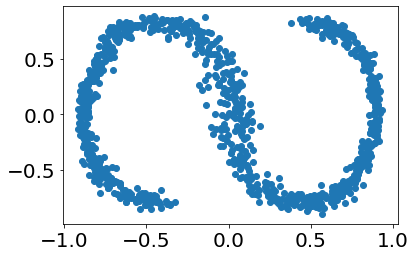

In [262]:
plt.scatter(Z_val_pred[0],
            Z_val_pred[1])

In [246]:
COLORMAP_DISCRETE = {0:'blue', 1:'red'}

df = pd.DataFrame(np.concatenate([outpt_train_pred.T,
                                  inpt.T], 0), columns=['x','y','z'])

df['train_pred'] = np.concatenate([np.zeros((T_train)),
                                   np.ones((inpt.shape[1]))])
fig = px.scatter_3d(df, 
                    x='x', 
                    y='y', 
                    z='z', 
                    color='train_pred', 
                    opacity=0.5,
                    color_discrete_sequence=["blue", "purple"]
                    )

fig.update_traces(marker_size=5)
fig.show()

In [247]:
df = pd.DataFrame(np.concatenate([outpt_val_pred.T,
                                  inpt_test.T], 0), columns=['x','y', 'z'])

df['val_pred'] = np.concatenate([np.zeros((T_val)),
                                 np.ones((T_val))])

fig = px.scatter_3d(df, x='x', y='y', z='z', color='val_pred', opacity=0.5)
fig.show()